In [1]:
from high_level import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
connect(instruments)
#reset(instruments)

In [4]:
instruments['OSC'].write("SYST:DISP:UPD 1")
instruments['DAQ'].set_conn(123)

## R&W

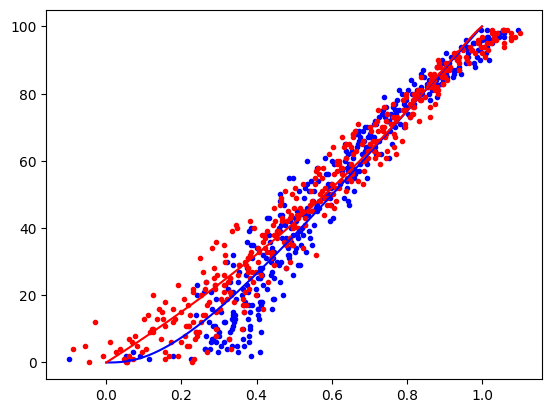

In [5]:
characterize(1)
P, R = characterize(4)
params = get_params(P, R)

In [6]:
params

{'N': 100,
 'A': 2.958600383497106e-05,
 'B': 1.607662270963715,
 'popt': {'s': array([ 0.31573443, -0.52336145]),
  'r': array([ 0.86371161, -0.02008162])}}

In [7]:
read(params)

0.07010449449991621

In [8]:
G = .4
write(params, G)
read(params)

0.46984981120851177

## AWG

In [20]:
wf_dict_AWG = {
    'V' : [*np.linspace(2.3, 2.6, N), *np.linspace(-2.4, -2.9, N)], # pulse voltages
    'n' : [1 for i in range(N*2)],   # pulse repetitions
    'W' : [2e-4 for i in range(N*2)],     # pulse widths
    'T' : 2e-3,     # pulse period
    'read' : True,
    'read_V' : read_V
}
get_and_set_wf('AWG', wf_dict_AWG, ch_AWG)

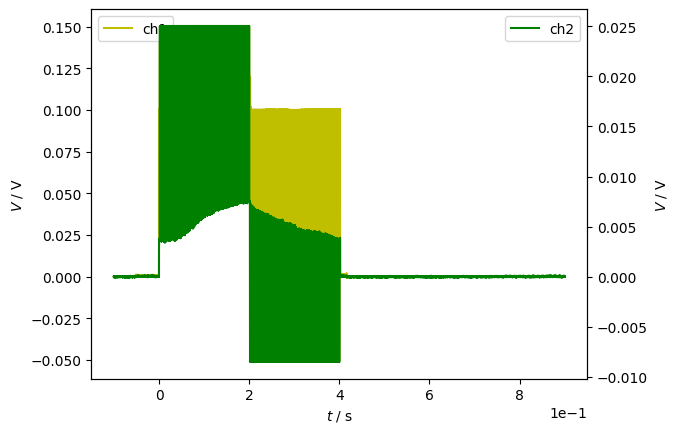

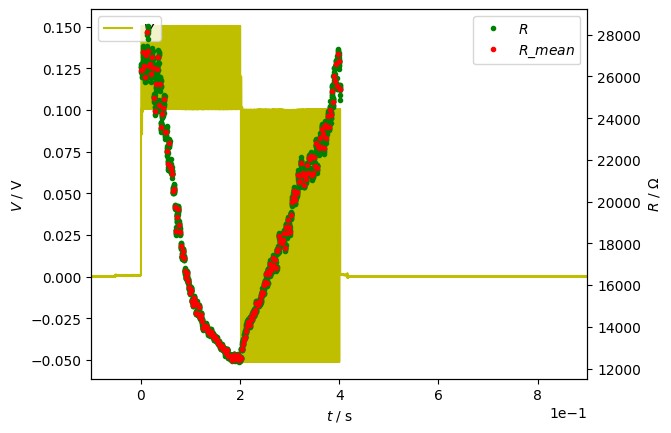

In [21]:
#meas_AWG(wf_dict_AWG, [1, 2], R_s=1e3, R_min=5e3, plot=False)
results_AWG = meas_AWG(wf_dict_AWG, [1, 2], R_s=1e3, R_min=5e3, save=True)

In [ ]:
#with open(f"meas_dict/AWG_.json", "r") as json_file:
#    meas_dict_AWG = json.load(json_file)

## SMU

In [5]:
wf_dict_SMU = {
    'V' : [1, -1],
    'n' : [10, 10],
    'W' : [2e-3, 2e-3],
    'T' : 1e-2,
    'read' : True,
    'read_V' : .1
}
get_and_set_wf('SMU', wf_dict_SMU, ch_SMU)

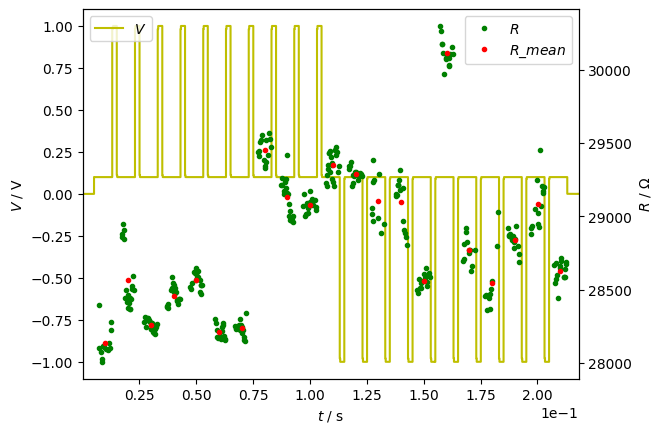

In [6]:
results_SMU = meas_SMU(wf_dict_SMU, [1, 2])

In [ ]:
#with open(f"meas_dict/SMU_.json", "r") as json_file:
#    meas_dict_SMU = json.load(json_file)

## AWG_SMU

In [5]:
g = 10
T = 1e-3
W = 2e-4
wf_dict_AWG_list = [
    {
        'V' : [-2.6],
        'n' : [g],
        'W' : [W],
        'T' : T,
        'read' : False,
        'read_V' : 0
    }, {
        'V' : [2.4],
        'n' : [g],
        'W' : [W],
        'T' : T,
        'read' : False,
        'read_V' : 0
    }
]
wf_dict_SMU = {
    'V' : [0],
    'n' : [0],
    'W' : [0],
    'T' : 1,
    'read' : True,
    'read_V' : .1
}

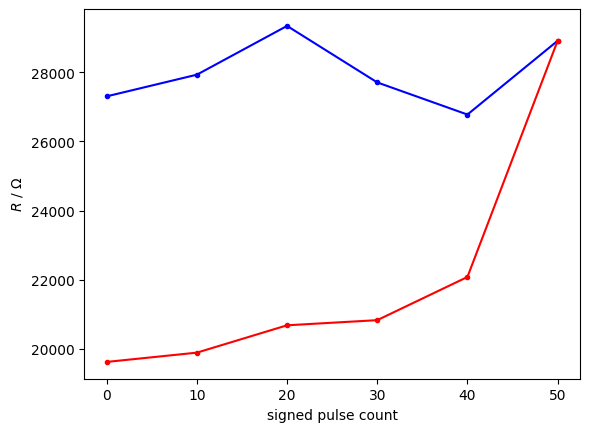

In [6]:
n = [5, 5]
results = meas_AWG_SMU(wf_dict_AWG_list, n, wf_dict_SMU, R_s = 1e3)
#results = meas_AWG_SMU([], [], wf_dict_SMU, R_s = 1e3)